In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os
import feather

In [3]:
salesdata = feather.read_dataframe("../input/tmp_R_sales_with_buyers.feather")

In [4]:
taxdata=feather.read_dataframe("../input/tmp_R_sales.feather",
                               columns=['assessmentyear','parcelid','totalassessedvalue','landassessedvalue',
                                        'improvementassessedvalue','totalmarketvalue',
                                       'taxvaluedollarcnt','taxamount','state', 'county'])

In [5]:
salesdata['state'].value_counts()

39    2692812
06    2348037
37    2000072
36     674182
19     449357
na      22910
Name: state, dtype: int64

In [6]:
subsales=salesdata[salesdata['state']=="37"]

In [7]:
subsales[subsales['county']=='19085'].head()

Empty DataFrame
Columns: [regionidcounty, transactionyear, recordingdate, parcelid, legalrecordingid, createdate, documenttypeid, concurrentloanamount, concurrentloancount, dataclasstypeid, deedsloanamount, loanamount, loancount, saleprice, partialinteresttransferpercent, partialinteresttransfertypeid, inclusionruleidzestimate, derivedloanamount, derivedloancount, sellertype, numseller, buyertype, numbuyer, state, county, tract]
Index: []

[0 rows x 26 columns]

In [35]:
pid=subsales.iloc[int(np.random.random()*len(subsales))].parcelid
pid

106813081

In [36]:
#pid=161905457

In [37]:
subsales[subsales['parcelid']==pid].T

5981678              5992193  \
regionidcounty                                 1285                 1285   
transactionyear                                2014                 2012   
recordingdate                   2014-01-21 00:00:00  2012-02-10 00:00:00   
parcelid                                  106813081            106813081   
legalrecordingid                          438776553            438756330   
createdate                      2016-01-29 00:00:00  2016-01-29 00:00:00   
documenttypeid                                  138                   54   
concurrentloanamount                            NaN                  NaN   
concurrentloancount                             NaN                  NaN   
dataclasstypeid                                   2                    2   
deedsloanamount                                   0                    0   
loanamount                                      NaN                  NaN   
loancount                                         0                    0   
saleprice                                    235000            1.105e+06   
partialinteresttransferpercent                  NaN                  NaN   
partialinteresttransfertypeid                   NaN                  NaN   
inclusionruleidzestimate                          1                    0   
derivedloanamount                               NaN                  NaN   
derivedloancount                                NaN                  NaN   
sellertype                                       13                   13   
numseller                                         1                    1   
buyertype                                                             13   
numbuyer                                          1                    1   
state                                            37                   37   
county                                        37133                37133   
tract                                   37133000102          37133000102   

                                            5997880  
regionidcounty                                 1285  
transactionyear                                2010  
recordingdate                   2010-12-30 00:00:00  
parcelid                                  106813081  
legalrecordingid                          438768265  
createdate                      2016-01-29 00:00:00  
documenttypeid                                   54  
concurrentloanamount                            NaN  
concurrentloancount                             NaN  
dataclasstypeid                                   2  
deedsloanamount                                   0  
loanamount                                      NaN  
loancount                                         0  
saleprice                                  1.95e+06  
partialinteresttransferpercent                  NaN  
partialinteresttransfertypeid                   NaN  
inclusionruleidzestimate                          0  
derivedloanamount                               NaN  
derivedloancount                                NaN  
sellertype                                    13,29  
numseller                                         2  
buyertype                                        13  
numbuyer                                          1  
state                                            37  
county                                        37133  
tract                                   37133000102

In [38]:
b=taxdata[taxdata.parcelid==pid].sort_values("assessmentyear")
b['r']=np.exp(np.log(b['totalassessedvalue']).diff())-1
b['share']=b.landassessedvalue/b.totalassessedvalue

In [39]:
b

assessmentyear   parcelid  totalassessedvalue    taxamount  \
26190654            2014  106813081            240930.0  2469.540039   
17528962            2015  106813081            240930.0  2469.540039   
8302455             2016  106813081            240930.0  2469.540039   

          taxvaluedollarcnt  landassessedvalue  totalmarketvalue  \
26190654           240930.0                NaN          240930.0   
17528962           240930.0                NaN          240930.0   
8302455            240930.0                NaN          240930.0   

          improvementassessedvalue state county    r  share  
26190654                       NaN    37  37133  NaN    NaN  
17528962                       NaN    37  37133  0.0    NaN  
8302455                        NaN    37  37133  0.0    NaN

In [40]:
totalassessedvalue=pd.pivot_table(taxdata, index='parcelid', values='totalassessedvalue',columns='assessmentyear',aggfunc='first')

In [41]:
totalassessedvalue.head()

assessmentyear  2007  2008  2009      2010      2011      2012      2013  \
parcelid                                                                   
8921076          NaN   NaN   NaN  202000.0  190000.0  198900.0  202877.0   
8921077          NaN   NaN   NaN  205000.0  204000.0  190000.0  205000.0   
8921078          NaN   NaN   NaN  204000.0  204000.0  185000.0  188700.0   
8921079          NaN   NaN   NaN  194537.0  196001.0  199921.0  203918.0   
8921080          NaN   NaN   NaN  278000.0  278000.0  230520.0  235130.0   

assessmentyear      2014      2015      2016      2017  
parcelid                                                
8921076         203797.0  207870.0  211038.0  215257.0  
8921077         222178.0  226615.0  230070.0  234668.0  
8921078         189555.0  193343.0  196290.0  200215.0  
8921079         204843.0  208934.0  212118.0  216360.0  
8921080         236196.0  240915.0  244587.0  249478.0

In [42]:
totalassessedvalue_ratio=np.exp(np.log(totalassessedvalue).diff(axis=1))-1

In [43]:
totalassessedvalue_ratio.head()

assessmentyear  2007  2008  2009  2010      2011      2012      2013  \
parcelid                                                               
8921076          NaN   NaN   NaN   NaN -0.059405  0.046842  0.019995   
8921077          NaN   NaN   NaN   NaN -0.004879 -0.068627  0.078947   
8921078          NaN   NaN   NaN   NaN  0.000000 -0.093137  0.020000   
8921079          NaN   NaN   NaN   NaN  0.007525  0.020000  0.019993   
8921080          NaN   NaN   NaN   NaN  0.000000 -0.170791  0.019998   

assessmentyear      2014      2015      2016      2017  
parcelid                                                
8921076         0.004534  0.019986  0.015240  0.019992  
8921077         0.083795  0.019970  0.015246  0.019985  
8921078         0.004531  0.019984  0.015242  0.019996  
8921079         0.004536  0.019971  0.015239  0.019997  
8921080         0.004534  0.019979  0.015242  0.019997

In [44]:
state_parcelids = taxdata['parcelid'][taxdata['state']=='37'].value_counts().index

In [45]:
state_ratio=totalassessedvalue_ratio.loc[state_parcelids]

In [46]:
for col in state_ratio.columns:
    a=state_ratio[col].dropna().values
    if len(a>0):
        print col, np.percentile(a,[10,30,50,70,90]), len(a)

2008 [ 0.          0.          0.          0.          0.20621419] 1291662
2009 [ 0.          0.          0.          0.          0.20249358] 1271694
2010 [ 0.  0.  0.  0.  0.] 1736513
2011 [-0.01206595  0.          0.          0.          0.06081471] 2145775
2012 [-0.06770545  0.          0.          0.          0.        ] 2218618
2013 [-0.01430011  0.          0.          0.          0.        ] 2010725
2014 [ 0.  0.  0.  0.  0.] 1740182
2015 [-0.06532496  0.          0.          0.          0.        ] 2028971
2016 [-0.03694373  0.          0.          0.          0.01565671] 2425817
2017 [-0.06054467  0.          0.          0.          0.05140567] 1715703


In [49]:
tmpa = taxdata[['parcelid','county']][taxdata['state']=='37']
counties=tmpa['county'].value_counts().index
counties.shape

(97,)

In [50]:
for county in counties:
    county_parcelids=tmpa[tmpa['county']==county]['parcelid'].values
    print ""
    for col in state_ratio.columns:
        a=state_ratio.loc[county_parcelids,col].dropna().values
        if len(a>100):
            print county, col, np.round(np.percentile(a,[10,30,50,70,90]),3), len(a)


37119 2008 [ 0.  0.  0.  0.  0.] 2755097
37119 2009 [ 0.  0.  0.  0.  0.] 2923327
37119 2010 [ 0.  0.  0.  0.  0.] 3090545
37119 2011 [-0.175 -0.039  0.063  0.181  0.426] 3114351
37119 2012 [ 0.  0.  0.  0.  0.] 3140434
37119 2013 [-0.007 -0.002  0.     0.     0.   ] 3151642
37119 2014 [ 0.  0.  0.  0.  0.] 2264592
37119 2015 [-0.106  0.     0.     0.     0.   ] 2269778
37119 2016 [ 0.  0.  0.  0.  0.] 3173125
37119 2017 [ 0.  0.  0.  0.  0.] 3179411

37183 2008 [ 0.     0.     0.     0.     0.352] 134
37183 2009 [-0.303  0.     0.     0.     0.22 ] 294
37183 2010 [ 0.  0.  0.  0.  0.] 2773587
37183 2011 [ 0.  0.  0.  0.  0.] 2816032
37183 2012 [ 0.  0.  0.  0.  0.] 2840210
37183 2013 [ 0.  0.  0.  0.  0.] 2863669
37183 2014 [ 0.  0.  0.  0.  0.] 2885472
37183 2015 [ 0.  0.  0.  0.  0.] 2916098
37183 2016 [-0.106 -0.036  0.002  0.045  0.131] 2919944
37183 2017 [ 0.  0.  0.  0.  0.] 2921473

37081 2008 [ 0.  0.  0.  0.  0.] 1075733
37081 2009 [ 0.  0.  0.  0.  0.] 1099596
37081 2010 [ 

37151 2014 [ 0.  0.  0.  0.  0.] 115
37151 2015 [-0.011  0.     0.     0.     0.   ] 360
37151 2016 [ 0.     0.     0.     0.     0.047] 381
37151 2017 [-0.027 -0.013  0.     0.032  0.236] 72

37049 2008 [ 0.  0.  0.  0.  0.] 341851
37049 2009 [ 0.  0.  0.  0.  0.] 346449
37049 2010 [ 0.198  0.325  0.423  0.586  1.016] 348794
37049 2011 [-0.034  0.     0.     0.     0.   ] 350125
37049 2012 [ 0.  0.  0.  0.  0.] 350974
37049 2013 [ 0.  0.  0.  0.  0.] 352101
37049 2014 [ 0.  0.  0.  0.  0.] 352752
37049 2015 [ 0.  0.  0.  0.  0.] 353187
37049 2016 [ 0.  0.  0.  0.  0.] 353464
37049 2017 [-0.231 -0.155 -0.11  -0.077 -0.02 ] 353503

37027 2008 [ 0.  0.  0.  0.  0.] 340843
37027 2009 [ 0.  0.  0.  0.  0.] 341187
37027 2010 [ 0.  0.  0.  0.  0.] 341989
37027 2011 [ 0.  0.  0.  0.  0.] 342478
37027 2012 [ 0.  0.  0.  0.  0.] 342896
37027 2013 [-0.143  0.007  0.053  0.112  0.259] 344277
37027 2014 [ 0.  0.  0.  0.  0.] 344964
37027 2015 [ 0.  0.  0.  0.  0.] 345889
37027 2016 [ 0.  0.  0.  0

37195 2017 [ 0.  0.  0.  0.  0.] 98318

37175 2011 [ 0.  0.  0.  0.  0.] 92948
37175 2012 [ 0.  0.  0.  0.  0.] 90601
37175 2013 [ 0.  0.  0.  0.  0.] 91718
37175 2014 [ 0.     0.     0.     0.     0.016] 92038
37175 2015 [ 0.  0.  0.  0.  0.] 94438
37175 2016 [-0.15  -0.075 -0.06  -0.026  0.084] 96959

37145 2011 [ 0.  0.  0.  0.  0.] 89792
37145 2012 [ 0.  0.  0.  0.  0.] 90315
37145 2015 [ 0.  0.  0.  0.  0.] 91445
37145 2016 [ 0.  0.  0.  0.  0.] 91916
37145 2017 [ 0.  0.  0.  0.  0.] 91949

37165 2008 [ 0.  0.  0.  0.  0.] 84767
37165 2009 [ 0.  0.  0.  0.  0.] 85498
37165 2010 [ 0.  0.  0.  0.  0.] 85765
37165 2011 [-0.928 -0.858 -0.751 -0.402  0.125] 654
37165 2012 [  0.141   1.204   3.561   6.138  15.505] 549
37165 2013 [ 0.  0.  0.  0.  0.] 72254
37165 2014 [ 0.  0.  0.  0.  0.] 681
37165 2015 [ -0.39    1.1     2.736   5.885  15.505] 724
37165 2016 [ 0.  0.  0.  0.  0.] 87406
37165 2017 [-0.017 -0.017 -0.009  0.     0.   ] 6

37191 2011 [ 0.  0.  0.  0.  0.] 20
37191 2012 [-0

37121 2012 [ 0.  0.  0.  0.  0.] 20230
37121 2013 [-0.346  0.     0.     0.     0.   ] 20506
37121 2016 [ 0.  0.  0.  0.  0.] 20569

37091 2011 [-0.082  0.062  0.148  0.223  0.33 ] 17527
37091 2012 [ 0.  0.  0.  0.  0.] 18644
37091 2013 [ 0.  0.  0.  0.  0.] 18699
37091 2014 [ 0.  0.  0.  0.  0.] 7
37091 2015 [ 0.  0.  0.  0.  0.] 7
37091 2016 [ 0.  0.  0.  0.  0.] 18839

37073 2011 [ 0.  0.  0.  0.  0.] 14789
37073 2012 [ 0.  0.  0.  0.  0.] 14740
37073 2013 [ 0.  0.  0.  0.  0.] 14814
37073 2016 [ 0.  0.  0.  0.  0.] 15083

37029 2011 [ 0.  0.  0.  0.  0.] 10290
37029 2016 [ 0.  0.  0.  0.  0.] 12980
37029 2017 [ 0.  0.  0.  0.  0.] 12980

37103 2011 [ 0.  0.  0.  0.  0.] 12084
37103 2012 [ 0.  0.  0.  0.  0.] 12154
37103 2013 [ 0.  0.  0.  0.  0.] 12249
37103 2014 [ 0.  0.  0.  0.  0.] 4
37103 2016 [ 0.  0.  0.  0.  0.] 12648

37185 2008 [ 0.  0.  0.  0.  0.] 11
37185 2009 [ 0.  0.  0.  0.  0.] 11
37185 2010 [ 0.  0.  0.  0.  0.] 11
37185 2011 [ 0.  0.  0.  0.  0.] 11
37185 2012 [ 0

In [155]:
print """
  1. each county assesment every 4 to 8 years (schedule is different for counties)
  2. assesment date is Jan 1st.
  3. increase ratio of zero means that the county level sales ratio median is less than 5% (abs value)
  4. fill zero increase with hpi or sales ratio
  6. if totalmarketvalue exists, it seems totalmarketvalue is more reasonable (one of them is incorrect)
"""


  1. missing assesment value can be derives from tax amount by tax rate (countywise)
  2. assesment on odd year, assesment date is Jan 1st.
  3. increase ratio of zero means that the county level sales ratio median is less than 5% (abs value)
  4. fill zero increase with hpi
  5. use sales ratio to adjust assesment 
  6. if totalmarketvalue exists, it seems totalmarketvalue is more reasonable (one of them is incorrect)



In [128]:
a=taxdata[taxdata['state']=='37']

In [52]:
b=(a['totalmarketvalue']/a['totalassessedvalue']).dropna()
b.shape

(17279498,)

In [62]:
np.where(b>10)

(array([  123670,   127490,   193457, ..., 17000929, 17006503, 17017702]),)

In [69]:
b.index[123670]

396686

In [70]:
taxdata.iloc[396686]

assessmentyear                   2017
parcelid                    171656130
totalassessedvalue               2320
taxamount                       18.64
taxvaluedollarcnt               25820
landassessedvalue                 nan
totalmarketvalue                25820
improvementassessedvalue          nan
state                              37
county                          37127
Name: 396686, dtype: object

In [53]:
a.shape

(25840247, 10)

In [127]:
salesdata[salesdata.parcelid==97638582].T

7617495              7638116
regionidcounty                                  324                  324
transactionyear                                2015                 2014
recordingdate                   2015-01-07 00:00:00  2014-03-26 00:00:00
parcelid                                   97638582             97638582
legalrecordingid                          176122040            176146441
createdate                      2016-01-29 00:00:00  2016-01-29 00:00:00
documenttypeid                                  138                  138
concurrentloanamount                         515516                  NaN
concurrentloancount                               1                  NaN
dataclasstypeid                                   5                    2
deedsloanamount                              515516                    0
loanamount                                   515516                  NaN
loancount                                         1                    0
saleprice                                    644500               125000
partialinteresttransferpercent                  NaN                  NaN
partialinteresttransfertypeid                   NaN                  NaN
inclusionruleidzestimate                          1                    1
derivedloanamount                               NaN                  NaN
derivedloancount                                NaN                  NaN
sellertype                                       13                   13
numseller                                         1                    1
buyertype                                     41,41                   13
numbuyer                                          2                    1
state                                            37                   37
county                                        37183                37183
tract                                   37183053411          37183053411

In [129]:
a[a.parcelid==97638582].sort_values('assessmentyear')

assessmentyear  parcelid  totalassessedvalue    taxamount  \
19681900            2015  97638582            129000.0  5563.620117   
10533849            2016  97638582            673220.0  6418.959961   
1728910             2017  97638582            673220.0  6516.569824   

          taxvaluedollarcnt  landassessedvalue  totalmarketvalue  \
19681900           129000.0           129000.0          129000.0   
10533849           673220.0           148000.0          673220.0   
1728910            673220.0           148000.0          673220.0   

          improvementassessedvalue state county  
19681900                       NaN    37  37183  
10533849                  525220.0    37  37183  
1728910                   525220.0    37  37183

In [55]:
b[b<>1].shape,b.shape

((441041,), (17279498,))

In [56]:
len(set(a.loc[b[b<>1].index,'parcelid']).intersection(subsales['parcelid']))

68581

In [77]:
c=taxdata[taxdata.parcelid.isin(set(a.loc[b[b<>1].index,'parcelid']).intersection(subsales['parcelid']))]
c['ratio']=c['totalmarketvalue']/c['totalassessedvalue']
c=c.sort_values('ratio',ascending=False)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [79]:
c.head()

assessmentyear   parcelid  totalassessedvalue   taxamount  \
59203693            2010  103124085                 1.0         NaN   
66678742            2009  103124085                 1.0         NaN   
32919588            2013  107639615                10.0         NaN   
40840291            2012  107639615                10.0         NaN   
1434797             2017  102693580               110.0  871.049988   

          taxvaluedollarcnt  landassessedvalue  totalmarketvalue  \
59203693           350000.0                1.0          350000.0   
66678742           350000.0                1.0          350000.0   
32919588            17020.0                NaN           17020.0   
40840291            17020.0                NaN           17020.0   
1434797            158980.0                NaN          158980.0   

          improvementassessedvalue state county          ratio  
59203693                       NaN    37  37031  350000.000000  
66678742                       NaN    37  37031  350000.000000  
32919588                       NaN    37  37147    1702.000000  
40840291                       NaN    37  37147    1702.000000  
1434797                      110.0    37  37019    1445.272705

In [57]:
list(set(a.loc[b[b<>1].index,'parcelid']).intersection(subsales['parcelid']))[:100]

[105644033,
 108309163,
 105119748,
 102629381,
 106823687,
 108309164,
 106823694,
 105644051,
 108309166,
 105644054,
 106858474,
 102498331,
 102629407,
 108789792,
 105644066,
 108789795,
 102629414,
 106212017,
 108352860,
 108352861,
 105250865,
 108309171,
 102629429,
 105250871,
 102629432,
 105250874,
 105644092,
 108789821,
 108789822,
 108789823,
 105250880,
 105119809,
 105119810,
 105250888,
 106823753,
 108789835,
 108789836,
 106823767,
 108789848,
 105644123,
 105603936,
 102629477,
 105644134,
 106227369,
 102629480,
 102629481,
 102629482,
 108789867,
 108789868,
 108789870,
 108789873,
 108789874,
 102629491,
 105644148,
 102629493,
 105644150,
 108309183,
 105382014,
 108308703,
 108805911,
 106212032,
 108789890,
 108261930,
 108789892,
 102629509,
 105250951,
 108789897,
 108265612,
 108309186,
 102629518,
 102629522,
 108789909,
 102629526,
 102629528,
 105119897,
 102629530,
 108789915,
 102629533,
 108789919,
 108352880,
 102629538,
 103153829,
 102629542,
 102

In [84]:
sale_tax=pd.merge(subsales,taxdata, left_on=['parcelid',u'transactionyear'], 
                  right_on=['parcelid',u'assessmentyear'],how='left')
sale_tax['ratio']=sale_tax['saleprice']/sale_tax[u'totalassessedvalue']
sale_tax=sale_tax.sort_values('ratio',ascending=False)
sale_tax=sale_tax[sale_tax['inclusionruleidzestimate']>0]

In [118]:
sale_tax[sale_tax.ratio<5].head()

regionidcounty  transactionyear recordingdate   parcelid  \
1518716             962             2008    2008-05-12  103361410   
1474159             999             2010    2010-06-24  103952886   
1730721             324             2015    2015-01-07   97638582   
1129989            1712             2014    2014-11-25  104153534   
537820             2640             2016    2016-04-11  102630929   

         legalrecordingid createdate  documenttypeid  concurrentloanamount  \
1518716         435094574 2016-01-29           138.0                   NaN   
1474159         435523305 2016-01-29           138.0              201158.0   
1730721         176122040 2016-01-29           138.0              515516.0   
1129989         436597514 2016-01-29           128.0              143398.0   
537820          544530552 2016-08-23           128.0                   NaN   

         concurrentloancount  dataclasstypeid    ...     assessmentyear  \
1518716                  NaN              2.0    ...             2008.0   
1474159                  1.0              5.0    ...             2010.0   
1730721                  1.0              5.0    ...             2015.0   
1129989                  1.0              5.0    ...             2014.0   
537820                   NaN              2.0    ...             2016.0   

         totalassessedvalue    taxamount  taxvaluedollarcnt  \
1518716             41020.0          NaN            41020.0   
1474159             41025.0   532.419983            41025.0   
1730721            129000.0  5563.620117           129000.0   
1129989             29325.0   368.239990            29325.0   
537820              21220.0  1110.849976           121060.0   

         landassessedvalue  totalmarketvalue  improvementassessedvalue  \
1518716             2600.0           41020.0                   38420.0   
1474159            41025.0               NaN                       NaN   
1730721           129000.0          129000.0                       NaN   
1129989            29325.0               NaN                       NaN   
537820             20000.0          121060.0                    1220.0   

         state_y  county_y     ratio  
1518716       37     37049  4.997562  
1474159       37     37063  4.996953  
1730721       37     37183  4.996124  
1129989       37     37067  4.995738  
537820        37     37019  4.995287  

[5 rows x 36 columns]

In [116]:
a=sale_tax[sale_tax.ratio>3]
a=a[a.ratio<10]
a.shape

(45663, 36)

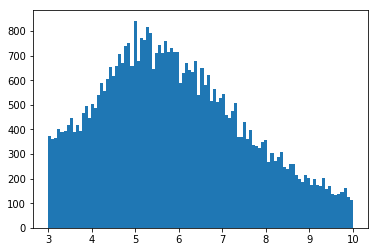

In [117]:
plt.hist( a.ratio,bins=100);

In [121]:
a.assessmentyear.value_counts()

2015.0    6185
2007.0    5638
2014.0    5528
2013.0    5196
2016.0    5125
2012.0    3826
2008.0    3601
2010.0    3282
2009.0    3165
2011.0    2919
2017.0    1198
Name: assessmentyear, dtype: int64

In [125]:
a[u'county_x'].value_counts()

37119    12502
37063     5081
37183     4535
37179     4329
37025     3420
37051     2725
37019     2302
37097     2042
37081     1562
37085     1261
37067      901
37021      634
37049      620
37071      472
37133      355
37001      320
37037      225
37089      183
37057      174
37157      172
37147      163
37151      155
37139      120
37129      119
37069       99
37141       99
37027       87
37077       81
37109       78
37135       62
         ...  
37059       12
37167       11
37015       11
37145       10
37191       10
37111        9
37169        8
37099        8
37039        7
37165        6
37113        6
37159        6
37103        5
37073        4
37123        4
37171        4
37009        4
37117        3
37115        3
37003        3
37181        3
37107        2
37185        2
37091        2
37005        2
37075        1
37043        1
37137        1
37029        1
37193        1
Name: county_x, Length: 79, dtype: int64